# Import toolkit

In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin


from sklearn.ensemble import RandomForestClassifier


C:\Users\liam.flood\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Get some data

In [2]:
data_draft = pd.read_csv('LendingClub_2007_2014_Cleaned_Reduced.csv', encoding = "ISO-8859-1")
data_draft.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit
0,10000,10000,10000.0,36 months,9.67%,321.13,B,B1,machinist,9 years,...,1,INDIVIDUAL,0,0.0,0,0.0,0.0,135462.0,10586.0,14500.0
1,22875,22875,22875.0,36 months,13.98%,781.60,C,C1,Campus Planner,5 years,...,1,INDIVIDUAL,0,0.0,0,0.0,0.0,193233.0,125668.0,14300.0
2,9800,9800,9800.0,36 months,10.99%,320.80,B,B2,sales merchandiser,10+ years,...,1,INDIVIDUAL,0,0.0,0,1.0,0.0,35782.0,20311.0,18200.0
3,15000,15000,15000.0,36 months,17.57%,539.06,D,D2,sales man,3 years,...,1,INDIVIDUAL,0,0.0,0,0.0,0.0,12200.0,7478.0,9000.0
4,19750,19750,19750.0,36 months,13.53%,670.51,B,B5,Accountant,10+ years,...,1,INDIVIDUAL,0,0.0,0,0.0,0.0,40616.0,15910.0,30200.0


# Encode text

In [3]:
text = data_draft[['grade','home_ownership','purpose','verification_status', 'zip_code']]

le = LabelEncoder()
encoded_text = text[text.columns[:]].apply(le.fit_transform)

# Get other relevant features
Two sets here to demonstrate effect of target leak.

In [4]:
#Take1: Huge target leak
reduced = data_draft[['loan_status','int_rate','dti','annual_inc','revol_bal','installment','loan_amnt', 'total_pymnt', 'collection_recovery_fee','total_pymnt_inv','total_rec_prncp']]

#Take2: No target leak
#reduced = data_draft[['loan_status','int_rate','dti','annual_inc','revol_bal','installment','loan_amnt']]



# Convert percents to numbers

In [5]:
reduced['int_rate'] = reduced['int_rate'].str.rstrip('%').astype(float)

# Join data together

In [6]:
data=reduced.join(encoded_text)
data.head()

,loan_status,int_rate,dti,annual_inc,revol_bal,installment,loan_amnt,total_pymnt,collection_recovery_fee,total_pymnt_inv,total_rec_prncp,grade,home_ownership,purpose,verification_status,zip_code
0,0,9.67,8.91,45000.0,7687,321.13,10000,10383.38000,0.0000,10383.38,10000.00,1,3,2,0,374
1,0,13.98,10.83,50000.0,15251,781.60,22875,24611.95990,0.0000,24611.96,22875.00,2,0,4,2,245
2,0,10.99,23.79,40000.0,15246,320.80,9800,11548.50395,0.0000,11548.50,9800.00,1,4,2,0,473
3,1,17.57,3.68,60000.0,7478,539.06,15000,10780.45000,290.9574,10780.45,6115.34,3,4,9,0,717
4,0,13.53,18.09,45000.0,15891,670.51,19750,21319.18702,0.0000,21319.19,19750.00,1,4,1,0,46


# Create some test data for later

In [7]:
data = shuffle(data)
test_data = data.tail(4000)
data = data.head(6000)

# Remove the target from the inputs 

In [8]:
data_inputs = data.drop(['loan_status'], axis=1)

# Set the target

In [9]:
expected_output = data[["loan_status"]]

# Slice and dice the data

In [10]:

sample_weight = np.random.RandomState(42).rand(expected_output.shape[0])
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(data_inputs, expected_output,sample_weight, test_size=0.4, random_state=42)


# Create the machine

In [11]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=100, max_features='sqrt', max_leaf_nodes=None,min_impurity_decrease=0.0, min_impurity_split=None,min_samples_leaf=4, min_samples_split=10,min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,oob_score=False, random_state=None, verbose=0,warm_start=False)

# Run the machine and score it

In [12]:
y_pred = rfc.fit(X_train, y_train.values.ravel()).predict(X_test)


rfc.score(X_test, y_test)*100

98.04166666666667

# Get some stats and confusion matrix

In [13]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2075
          1       1.00      0.86      0.92       325

avg / total       0.98      0.98      0.98      2400



In [14]:
print(metrics.confusion_matrix(y_test, y_pred))

[[2075    0]
 [  47  278]]


# See how important the features are

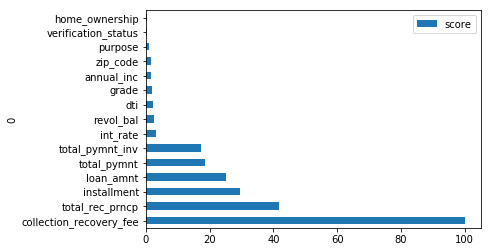

In [15]:
rows_list = []
for name, score in zip(list(data_inputs), rfc.feature_importances_):
    rows_list.append([name,score])
    
importances = pd.DataFrame(rows_list)
importances['score']=importances[1]/importances.max(0)[1]*100
importances.set_index(0,drop=True,inplace=True)
importances.sort_values('score', ascending=False)[['score']].plot.barh()

# Make a ROC curve and prediction distribution

[]

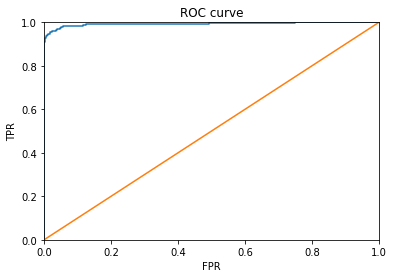

In [16]:
predictions = rfc.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0, 1], [0, 1])
plt.plot(size=(20,20))

In [17]:
predictions = rfc.predict_proba(X_test)
pred_df=pd.DataFrame({'ProbPredict0':predictions[:,0],'ProbPredict1':predictions[:,1],'Prediction':y_pred})
pred_df=pd.concat( [pred_df, y_test.reset_index(drop=True)], axis=1) 


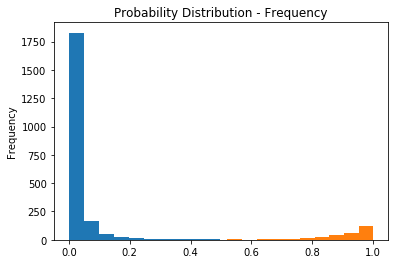

In [18]:
pred_df.loc[pred_df['Prediction'] == 0]['ProbPredict1'].plot(kind='hist')
pred_df.loc[pred_df['Prediction'] == 1]['ProbPredict1'].plot(kind='hist', title='Probability Distribution - Frequency')

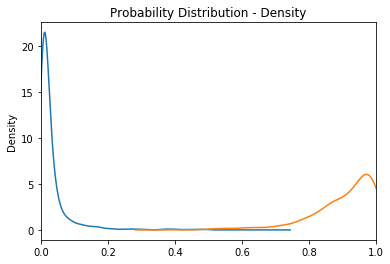

In [19]:
pred_df.loc[pred_df['Prediction'] == 0]['ProbPredict1'].plot(kind='kde')
pred_df.loc[pred_df['Prediction'] == 1]['ProbPredict1'].plot(kind='kde', title='Probability Distribution - Density', xlim=(0,1))

In [20]:
#set some "live" thresholds. see https://stackoverflow.com/questions/32627926/scikit-changing-the-threshold-to-create-multiple-confusion-matrixes

class CustomThreshold(BaseEstimator, ClassifierMixin):
    """ Custom threshold wrapper for binary classification"""
    def __init__(self, base, threshold=0.5):
        self.base = base
        self.threshold = threshold
    def fit(self, *args, **kwargs):
        self.base.fit(*args, **kwargs)
        return self
    def predict(self, X):
        return (self.base.predict_proba(X)[:, 1] > self.threshold).astype(int)


clf = [CustomThreshold(rfc, threshold) for threshold in [0.4, 0.5, 0.6]]

for model in clf:
    print(metrics.confusion_matrix(y_test, model.predict(X_test)))

[[2074    1]
 [  36  289]]
[[2075    0]
 [  47  278]]
[[2075    0]
 [  52  273]]


# Make a prediction

In [21]:
test_data['prediction'] = rfc.predict(test_data.drop(['loan_status'], axis=1))

result = test_data[['loan_status','prediction']]

result['got it right?'] = result['loan_status'] == result['prediction']

result.head()

,loan_status,prediction,got it right?
4318,1,1,True
9740,0,0,True
4668,0,0,True
6864,1,1,True
8720,0,0,True


In [22]:
pd.value_counts(result['got it right?'])

True     3932
False      68
Name: got it right?, dtype: int64

In [23]:
(pd.value_counts(result['got it right?'])[0]/4000)*100

1.7000000000000002

In [24]:
(pd.value_counts(result['got it right?'])[1]/4000)*100

98.3

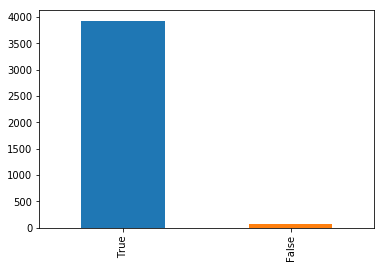

In [25]:

pd.value_counts(result['got it right?']).plot(kind='bar')
